****
# Part 1 · Reading in Survey Data

Import monthly SCE CSV files, harmonize column names, and report baseline sample statistics.
****


## 1.1
In this section we import the necessary Python packages, and read in all SCE files and combine them into a single DataFrame

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Pattern to match every SCE monthly CSV in the data folder
pattern = "data/SCE-*.csv"

# List that contains data frame
data = []
for file in glob.glob(pattern):
    # Files use semicolons as separators, so we need sep=';'
    d = pd.read_csv(file, sep=";")
    data.append(d)

# Stack all the csv files into one DataFrame and reset the index
df = pd.concat(data, ignore_index=True)

# Ensure the date column behaves like a datetime, then sort chronologically
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## 1.2
The following is a report to understand the sample sizes of the Survey of Consumer Expectations (SCE)

In [3]:
def sample_stats(df):
    """Print SCE panel statistics."""
    # Functions to get statistics
    n_individuals = df["userid"].nunique()
    n_observations = len(df)
    n_waves = df["wid"].nunique()
    date_min = df["date"].min().date()
    date_max = df["date"].max().date()

    # Present the statistics in a compact block
    format_length = 40
    print("=" * format_length)
    print("SCE Survey Data Summary".center(format_length))
    print("=" * format_length)
    print(f"Number of unique individuals: {n_individuals:,}".center(format_length))
    print(f"Total observations (rows):    {n_observations:,}".center(format_length))
    print(f"Number of survey waves:       {n_waves}".center(format_length))
    print(f"The first date observed is:   {date_min}".center(format_length))
    print(f"The last date observed is:    {date_max}".center(format_length))
    print("=" * format_length)

In [4]:
sample_stats(df)

        SCE Survey Data Summary         
  Number of unique individuals: 23,369  
 Total observations (rows):    176,101  
   Number of survey waves:       139    
The first date observed is:   2013-06-01
The last date observed is:    2024-12-31


****
# Part 2 · Data pre-processing
Dropping/filling missing observations and creating additional variables
****

## 2.1
Filling in the missing numeracy variables according to the values from the first observation

In [5]:
# Use list comprehention to collect every “num_lit_*_correct” column so we can work with the whole set at once
numeracy_cols = [
    col for col in df.columns if col.startswith("num_lit_") and col.endswith("correct")
]

# Within each respondent, forward/back-fill their numeracy answers to fill gaps
df[numeracy_cols] = df.groupby("userid")[numeracy_cols].transform(
    lambda s: s.ffill().bfill()
)

## 2.2 
Dropping all observations with missing values for specific variables

In [6]:
# Defining the column groups in order to drop the missing values
demographic_cols = ["female", "age", "educ"]
expectations_cols = ["inflation", "house_price_change", "prob_stocks_up"]

In [7]:
def drop_missing(df, cols):
    """Drop rows that miss any column in 'cols' and report how many were dropped.

    Parameters
    ----------
    df : pandas.DataFrame
        Input table to clean.
    cols : Iterable[str]
        Column names that must be present (non-null) in each retained row.

    Returns
    -------
    pandas.DataFrame
        Filtered copy of `df` with required columns non-missing.
    int
        Count of rows removed by the filter.
    """
    observations_before_drop = len(df)
    df_drop = df.dropna(subset=cols)
    return df_drop, observations_before_drop - len(df_drop)

In [8]:
# Define the column groups and their labels
data_groups = {
    "demographic": demographic_cols,
    "expectation": expectations_cols,
    "numeracy": numeracy_cols,
}


# Variables to help with formatting
initial_rows = len(df)
total_dropped = 0
lines = []
format_length = 66

# Loop to drop missing values from each group
for name, cols in data_groups.items():
    df, dropped = drop_missing(df, cols)
    total_dropped += dropped
    lines.append(
        f"Dropped {dropped:,} observations (rows) due to missing {name} data.".center(
            format_length
        )
    )

# Formatting and displaying all observations dropped at each step + total observations
print("=" * format_length)
print("Dropped Observations Summary".center(format_length))
print("=" * format_length)
print("\n".join(lines))
print("-" * format_length)
print(f"Total dropped observations: {total_dropped:,}".center(format_length))
print(f"Remaining total observations: {len(df):,}".center(format_length))
print("=" * format_length)

                   Dropped Observations Summary                   
 Dropped 868 observations (rows) due to missing demographic data. 
Dropped 1,683 observations (rows) due to missing expectation data.
 Dropped 35,974 observations (rows) due to missing numeracy data. 
------------------------------------------------------------------
                Total dropped observations: 38,525                
              Remaining total observations: 137,576               


## 2.3

Dropping outliers with implausible small or large values

In [9]:
def drop_outliers(df, col, lower_q=0.001, upper_q=0.999):
    """Trim extreme values in `col` by keeping only the quantile range [lower_q, upper_q].

    Parameters
    ----------
    df : pandas.DataFrame
        Source data.
    col : str
        Column name to filter.
    lower_q : float, optional
        Lower quantile cutoff (default 0.001).
    upper_q : float, optional
        Upper quantile cutoff (default 0.999).

    Returns
    -------
    pandas.DataFrame
        Copy of `df` with rows outside the quantile band removed.
    """
    # Compute quantile thresholds
    low_thresh = df[col].quantile(lower_q)
    high_thresh = df[col].quantile(upper_q)

    # Create masks for outliers
    below_mask = df[col] < low_thresh
    above_mask = df[col] > high_thresh

    # Variables to keep track of outliers
    dropped_low = below_mask.sum()
    dropped_high = above_mask.sum()

    # Drop the outliers
    clean_df = df[(df[col] >= low_thresh) & (df[col] <= high_thresh)].copy()
    print(f"{col}:".center(format_length))
    print(f"Dropped {dropped_low} rows below {low_thresh:.1f}%".center(format_length))
    print(f"Dropped {dropped_high} rows above {high_thresh:.1f}%".center(format_length))
    print(f"Remaining rows: {len(clean_df)}".center(format_length))
    return clean_df

In [10]:
# Drop extreme values in each expectations series
format_length = 30
print("=" * format_length)
print("Dropped Outliers Summary".center(format_length))
print("=" * format_length)
for col in expectations_cols:
    df = drop_outliers(df, col)
    print("=" * format_length)

   Dropped Outliers Summary   
          inflation:          
 Dropped 92 rows below -75.0% 
 Dropped 27 rows above 100.0% 
    Remaining rows: 137457    
     house_price_change:      
Dropped 133 rows below -50.0% 
 Dropped 46 rows above 100.0% 
    Remaining rows: 137278    
       prob_stocks_up:        
  Dropped 0 rows below 0.0%   
 Dropped 0 rows above 100.0%  
    Remaining rows: 137278    


## 2.4
New column 'college' that equals 1 if the respondent has a bachelor's degree or higher and 0 otherwise

In [11]:
df["college"] = (df["educ"] == 4).astype(int)

## 2.5
Summarizing the numeracy scores and defining new column 'num_lit_high' for above-median performance.

In [12]:
# Reporting % of the sample of correct responses
# For each individual compute the number of correct responses
numeracy_by_person = df.groupby("userid", as_index=False)[numeracy_cols].first()
numeracy_by_person["num_correct"] = numeracy_by_person[numeracy_cols].sum(axis=1)

# Share of respondents at each score
count_per_score = numeracy_by_person["num_correct"].value_counts().sort_index()
share_per_score = (count_per_score / len(numeracy_by_person) * 100).round(2)

# Flag anyone above the median number correct as "high numeracy"
median_correct = numeracy_by_person["num_correct"].median()
numeracy_by_person["num_lit_high"] = (
    numeracy_by_person["num_correct"] > median_correct
).astype(int)

# Merge the high-numeracy indicator back to the data frame
df = df.merge(numeracy_by_person[["userid", "num_lit_high"]], on="userid", how="left")

# Print score distribution
format_length = 35
print("=" * format_length)
print("Numerical Literacy Scores".center(format_length))
print("=" * format_length)
for score, pct in share_per_score.items():
    print(f"{pct}% of individuals got {int(score)} correct".center(format_length))
print("=" * format_length)

     Numerical Literacy Scores     
 0.14% of individuals got 0 correct
 0.73% of individuals got 1 correct
 2.4% of individuals got 2 correct 
 5.71% of individuals got 3 correct
10.51% of individuals got 4 correct
16.94% of individuals got 5 correct
27.41% of individuals got 6 correct
36.17% of individuals got 7 correct


## 2.6
The following is an updated report of the sample statistics for the Survey of Consumer Expectations (SCE)

In [13]:
sample_stats(df)

        SCE Survey Data Summary         
  Number of unique individuals: 17,701  
 Total observations (rows):    137,278  
   Number of survey waves:       117    
The first date observed is:   2015-04-02
The last date observed is:    2024-12-31


***
# Part 3 · Average expectations by group
Analysing the three different variables gender, college and numeracy individually
***


    

In [14]:
def compute_group_means(df, group_col, exp_cols):
    """Compute average expectation values within each subgroup.

    Parameters
    ----------
    df : pandas.DataFrame
        Cleaned survey data.
    group_col : str
        Column name whose categories define the groups (e.g., 'female').
    exp_cols : Iterable[str]
        Expectation columns to average, such as ['inflation', 'prob_stocks_up'].

    Returns
    -------
    pandas.DataFrame
        One row per group with the mean of each expectation column.
    """
    # Collapse to group-level averages for the requested expectation columns
    group_means = df.groupby(group_col)[exp_cols].mean().reset_index()
    return group_means

## 3.1
Computing the average expectations for inflation, house prices, stock market for each of the three variables

**Average expectations for males vs. females**

In [15]:
gender_means = compute_group_means(df, "female", expectations_cols)

**Average expectations for non-college vs. college**

In [16]:
college_means = compute_group_means(df, "college", expectations_cols)

**Average expectations for low vs. high numeracy**

In [17]:
num_means = compute_group_means(df, "num_lit_high", expectations_cols)

## 3.2
Computing the average expectations for inflation, house prices, stock market for each of the three variables

In [18]:
def plot_group_bars(
    group_means, group_labels, expectations_cols, title, colour1, colour2
):
    """Render side-by-side bar charts comparing expectations across two groups.

    Parameters
    ----------
    group_means : pandas.DataFrame
        Two-row table with one column per expectation metric.
    group_labels : Sequence[str]
        Display names for each group (order must match the rows in `group_means`).
    expectations_cols : Sequence[str]
        Expectation variables to plot, e.g. ['inflation', 'prob_stocks_up'].
    title : str
        Figure title describing the split (e.g., "Expectations by Gender").
    colour1 : str
        Colour for the first group’s bars (Matplotlib format).
    colour2 : str
        Colour for the second group’s bars (Matplotlib format).

    Returns
    -------
    matplotlib.figure.Figure
        Figure containing three bar charts (one per expectation variable).
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
    fig.suptitle(title, fontsize=14, fontweight="bold")
    palette = [colour1, colour2]

    # Compare the two group averages for this expectation metric
    for i, col in enumerate(expectations_cols):
        axes[i].bar(group_labels, group_means[col], color=palette, width=0.6)
        axes[i].set_title(col.replace("_", " ").capitalize(), fontsize=12)
        axes[i].set_ylabel("Average (%)")
        axes[i].margins(y=0.10)

        # Annotate bar heights for quick reading
        ymax = max(group_means[col])
        for idx, val in enumerate(group_means[col]):
            axes[i].text(idx, val + ymax * 0.03, f"{val:.1f}", ha="center", fontsize=10)
    plt.tight_layout()

**Average expectations by gender**

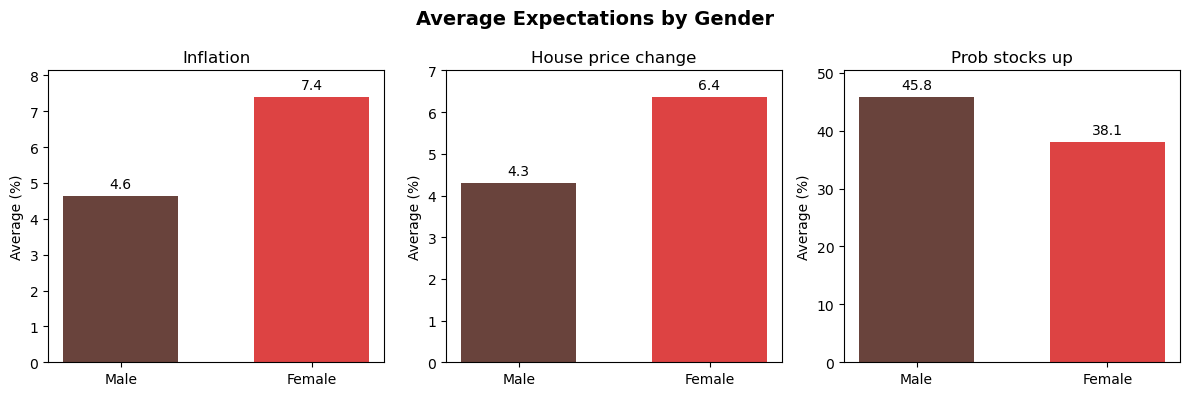

In [19]:
plot_group_bars(
    gender_means,
    group_labels=["Male", "Female"],
    expectations_cols=expectations_cols,
    title="Average Expectations by Gender",
    colour1="#4A1D14D4",
    colour2="#DD4343",
)

The cleaned SCE data frame shows that the average expectations vary across gender. Males are overall more optimistic, expecting lower inflation and housing price change and higher probability that stocks go up. 

**Average expectations by education**

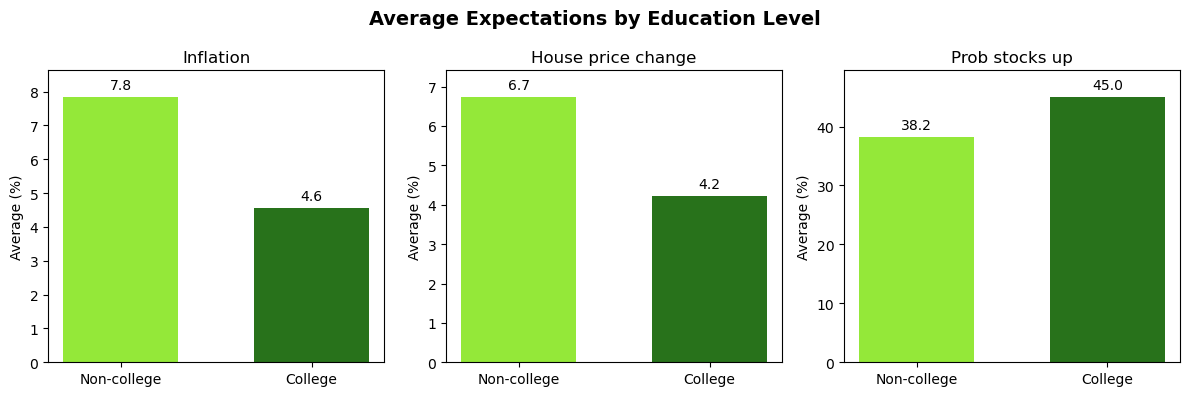

In [20]:
plot_group_bars(
    college_means,
    group_labels=["Non-college", "College"],
    expectations_cols=expectations_cols,
    title="Average Expectations by Education Level",
    colour1="#7EE411D4",
    colour2="#226F15F9",
)

Overall, the chart focusing on education levels shows that less-educated households anticipate a higher inflation and stronger growth in house prices, while being more skeptical about stock-market performance. In contrast, college-educated respondents appear more moderate in their inflation and housing expectations but show greater optimism regarding the stock market.

**Average expectations by numeracy**

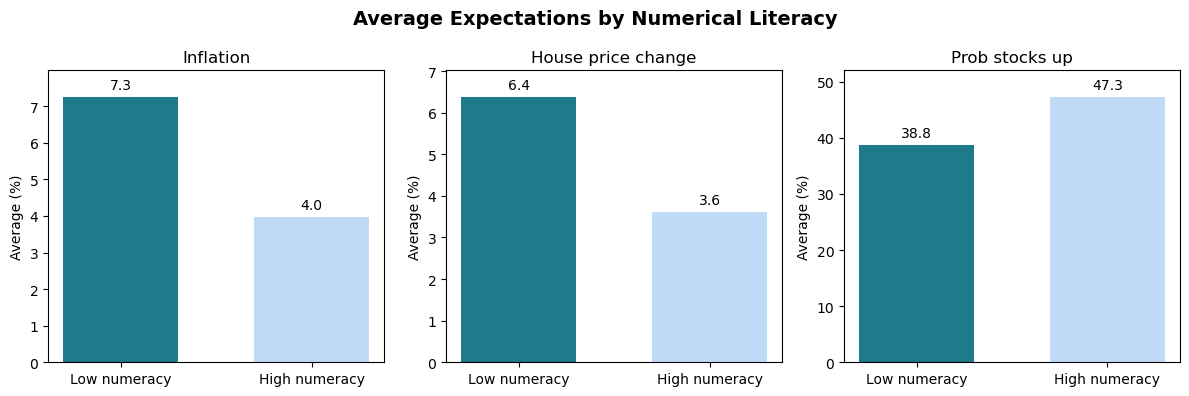

In [21]:
plot_group_bars(
    num_means,
    group_labels=["Low numeracy", "High numeracy"],
    expectations_cols=expectations_cols,
    title="Average Expectations by Numerical Literacy",
    colour1="#1F7A8C",
    colour2="#BFDBF7",
)

Respondents with below-median numerical literacy expect higher inflation and stronger growth in the housing market but expect a lower probability of stock prices increasing, compared to those with higher numerical literacy. This suggests that a higher numerical literacy is associated with more moderate price expectations and greater confidence in the stock market.

### **Conclusion**

Overall, the three bar charts reveal that groups who tend to be more financially informed or advantaged (men, college-educated, and high-numerical literacy) expect a lower inflation and increase for house prices but are more optimistic about stock market gains. Whereas women, lower education, and low-numeracy respondents expect a higher inflation and house price changes but show less confidence in the stock market.

***
# Part 4 · Expectation dynamics by group
Investigating how average expectations
evolved over time for the period of 2015-2024
***



    

## 4.1
Monthly averages grouped by gender, college degree and literacy regarding inflation, house prices,
stock market

In [22]:
def compute_monthly_expectations(
    df, group_col, exp_cols, start="2015-01-01", end="2024-12-31"
):
    """Collapse to monthly averages for each expectation variable within group

    Parameters
    ----------
    df : pandas.DataFrame
        Cleaned, dated survey microdata.
    group_col : str
        Column used to split the sample (e.g., 'female', 'college').
    exp_cols : Iterable[str]
        Expectation variables to aggregate.
    start : str or pandas.Timestamp, optional
    end : str or pandas.Timestamp, optional

    Returns
    -------
    pandas.DataFrame
        Monthly averages with columns ['date', group_col, *exp_cols].
    """
    # Resample within each group to month-end means
    monthly = (
        df.set_index("date")
        .groupby(group_col)[exp_cols]
        .resample("ME")
        .mean()
        .reset_index()
    )
    mask = (monthly["date"] >= start) & (monthly["date"] <= end)
    monthly = monthly.loc[mask].sort_values(["date", group_col]).reset_index(drop=True)
    return monthly.dropna(subset=exp_cols)

In [23]:
grouping_cols = ["female", "college", "num_lit_high"]

monthly_expectations = {}
for group_col in grouping_cols:
    monthly_expectations[group_col] = compute_monthly_expectations(
        df,
        group_col,
        expectations_cols,
    )

## 4.2
Figure that shows the monthly expectations of stocks increasing, changes in house prices, and inflation, differentiatet by gender, college, and numerical literacy.

In [24]:
# Plot monthly expectation time series by group (Task 4.2)
def plot_group_timeseries(
    monthly_data, group_col, expectation_cols, heading, colour1, colour2
):
    """Plot a 3×1 panel of average monthly expectations for a given grouping.

    Parameters
    ----------
    monthly_data : pandas.DataFrame
        Output from `compute_monthly_expectations`; must include `date`,
        `group_col`, and all columns listed in `expectation_cols`.
    group_col : str
        Grouping variable whose categories define the separate lines (e.g., 'female').
    expectation_cols : Sequence[str]
        Expectation series to chart (e.g., ['inflation', 'house_price_change', 'prob_stocks_up']).
    heading : str
        Text appended to the figure title (e.g., 'Gender').
    colour1 : str
        Matplotlib-compatible colour for the first group.
    colour2 : str
        Matplotlib-compatible colour for the second group.

    Returns
    -------
    matplotlib.figure.Figure
        Figure containing the three time-series panels stacked vertically.
    """
    groups = sorted(monthly_data[group_col].dropna().unique())
    labels = {
        "female": {0: "Male", 1: "Female"},
        "college": {0: "No College", 1: "College"},
        "num_lit_high": {0: "Low Numeracy", 1: "High Numeracy"},
    }.get(group_col, {})

    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(12, 9))
    fig.suptitle(f"Monthly Expectations by {heading}", fontsize=14)
    palette = {g: c for g, c in zip(groups, [colour1, colour2])}

    # Plot each expectation series with one line per subgroup
    for ax, column in zip(axes, expectation_cols):
        for group in groups:
            mask = monthly_data[group_col] == group
            label = labels.get(group, str(group))
            ax.plot(
                monthly_data.loc[mask, "date"],
                monthly_data.loc[mask, column],
                label=label,
                color=palette.get(group, colour1),
            )
        ax.set_ylabel(f"Average {column.replace('_', ' ').title()} (%)")
        ax.legend()

    events = {
        "Trump elected (1st)": "2016-11-08",
        "COVID-19 global": "2020-02-01",
        "Biden elected": "2020-11-03",
        "Ukraine invasion": "2022-02-24",
        "Jon Fosse Nobel": "2023-10-03",
        "Trump elected (2nd)": "2024-11-05",
    }
    # Annotate key events on every subplot
    for ax in axes:
        for label, date in events.items():
            d = pd.to_datetime(date)
            ax.axvline(d, color="gray", linestyle="--", linewidth=1, alpha=0.8)
            ymin, ymax = ax.get_ylim()
            ax.text(
                d,
                ymax * 0.98,
                label,
                rotation=90,
                va="top",
                ha="right",
                fontsize=8,
                color="gray",
            )

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    return fig

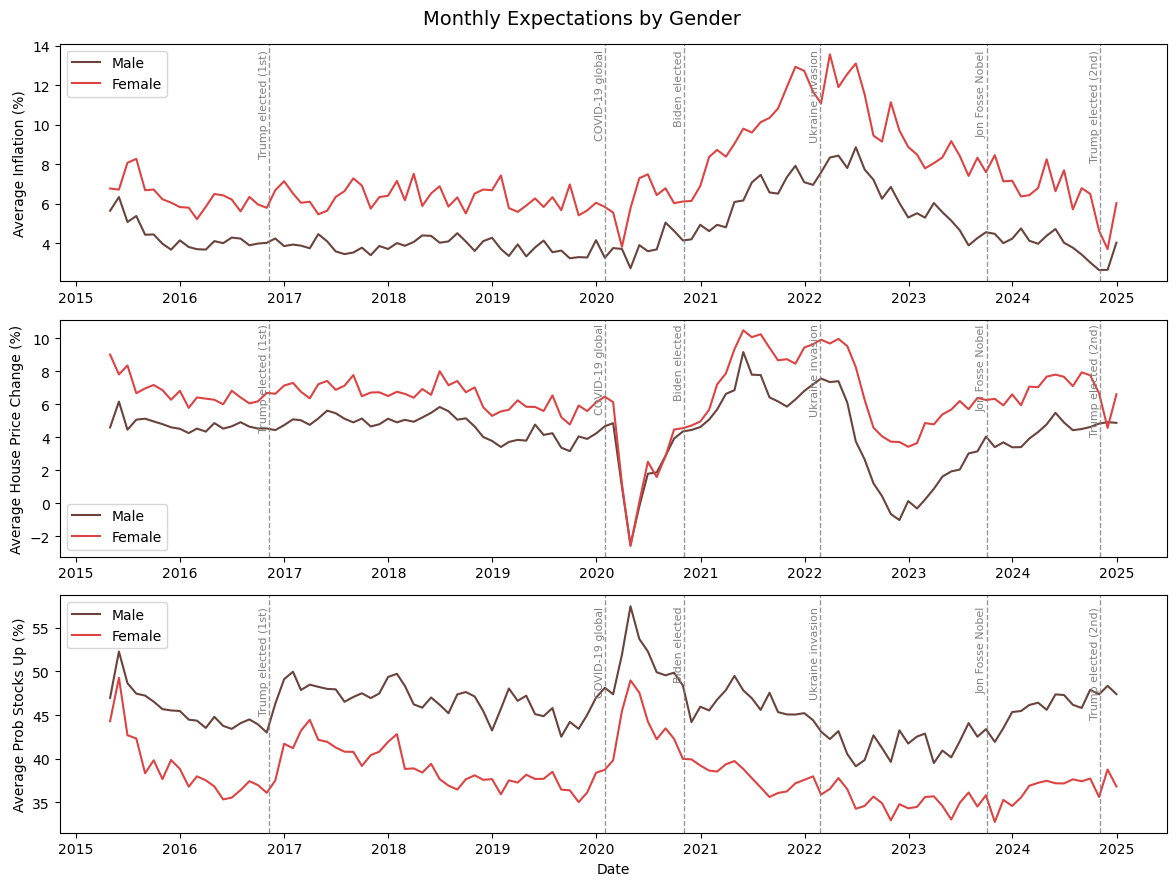

In [25]:
# Plot monthly expectations split by gender (Male vs Female)
fig = plot_group_timeseries(
    # pre-computed monthly averages for the gender split
    monthly_expectations["female"],
    "female",
    expectations_cols,
    "Gender",
    "#4A1D14D4",
    "#DD4343",
)

Several geopolitical and economic events appear to have significant changes on monthly expectations with differances between male and female. 

**Trump's first election (Nov 2016):**
Both genders recorded an almost equally sharp increase in the expected average probability of stock prices rising. Since the reaction was similar across genders, it likely reflects optimism about market performance driven by expectations of pro-business policies, such as tax cuts and deregulation. Because it likely was driven by macroeconomic sentiment, it also explains why there was an equal jump across genders.

**Covid-19 outbreak (Feb 2020):**
The pandemic led to a significant decline in the expected average housing price change across both genders, correlating with uncertainty and declining economic activity. At the same time, both males and females exhibited an equally sharp increase in the average expected probability that stock prices would rise. To mitigate the risk of a long-lasting economic decline, governments and central banks created fiscal and monetary stimulus packages, which helped lower the risk premia and increased the expected returns on equity. Another contributing factor was lower interest rates to stimulate the economy, which made equity more attractive compared to safe assets.
In addition, there was a greater decrease in average expected inflation by females than by males, suggesting stronger short-term deflation concerns.

**Biden's election:**
Around Biden's election, male respondents exhibited a decline in the expected average probability of increasing stock prices, possibly due to expectations of tightened regulations. However, the graph does not change for females, suggesting lower sensitivity to political change.

**Full-scale invasion of Ukraine:**
Both men and women expected rises in inflation after the Ukraine invasion, with women anticipating a large spike.

**Trump's second election:**
Female inflation expectations became more volatile. Whereas male expectations represented a more stable curve with a slight rise. Suggesting a different view on future polices.

**Summary:**
In summary, female inflation expectations appear more volatile, possibly being more reactive to household price pressures, such as groceries and rent. Whereas men's expectations seem more anchored and long-term. In regards of housing-price expectations, there is almost no changes across gender, besides males beeing generally more optimistic. The same goes for expected stock prices.

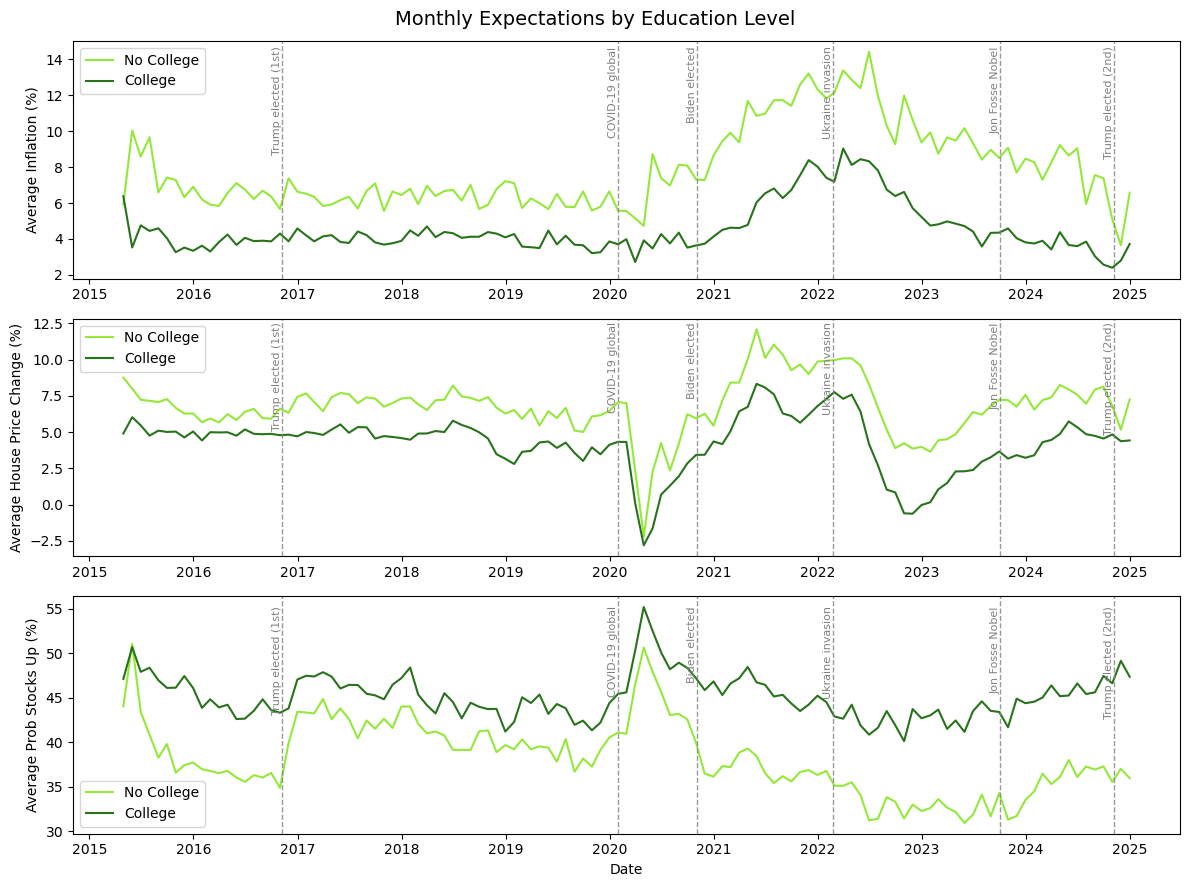

In [26]:
# Plot the monthly expectations panels for education groups (non-college vs college)
fig = plot_group_timeseries(
    monthly_expectations["college"],
    "college",
    expectations_cols,
    "Education Level",
    "#7EE411D4",
    "#226F15F9",
)

Geopolitical and economic events also shift monthly expectations for both college-educated and non-college groups.

**Trump's first election (Nov 2016):** After Trump was elected, both groups expected a price increase in the stock-market. The reason for this can be interpreted in the same way as stated in the graph for Expectations by Gender. Although respondents with no bachelor's degree showed a greater confidence, comperad to graduates. Respondents with no bachelor's degree likely turned more optimistic about stocks after Trump’s win because they expected his pro-business agenda to boost industries and jobs they rely on, while college-educated respondents remained more cautious.

**Covid-19 outbreak (Feb 2020):** After COVID hit, both education groups reacted similar to the Expectations by Gender graph and reflects the same reasoning. They also expected a sharp drop in house prices, converging on almost the same decline.
Later though the respondents with no bachelor's degree peeled away and expected a larger increase in house prices unlike graduates. Expected inflation also diverged sharply. Graduates stayed roughly level, while non-graduates expected a much higher inflation once COVID’s impact became clear. This split, both for house prices and inflation, reflects tight supply and stimulus-fueled demand in the starter-home market.

**Biden's election:** As the Democrats got back into office, expected growth for stocks and changes in house prices moved almost in parallel for both groups. Inflation expectations rose for both groups, yet non-graduates were noticeably more concerned with a higher inflation.

**Full scale invasion of Ukraine:** Similar to male and female expectations, both groups anticipate a rising inflation after the invasion and non-graduates expect a much higher inflation overall.

**Trump's second election:** Expected inflation grew after Trump regained his presidency. Graduates expected this earlier than non-graduates.

**Summary:** Geopolitical shocks kept reshaping expectations, reset expectations for both education groups, but non-graduates swung harder. They embraced Trump’s pro-business agenda, braced more for inflation through COVID and Biden’s victory, and reacted more sharply to the Ukraine invasion and Trump's return, while graduates stayed steadier.

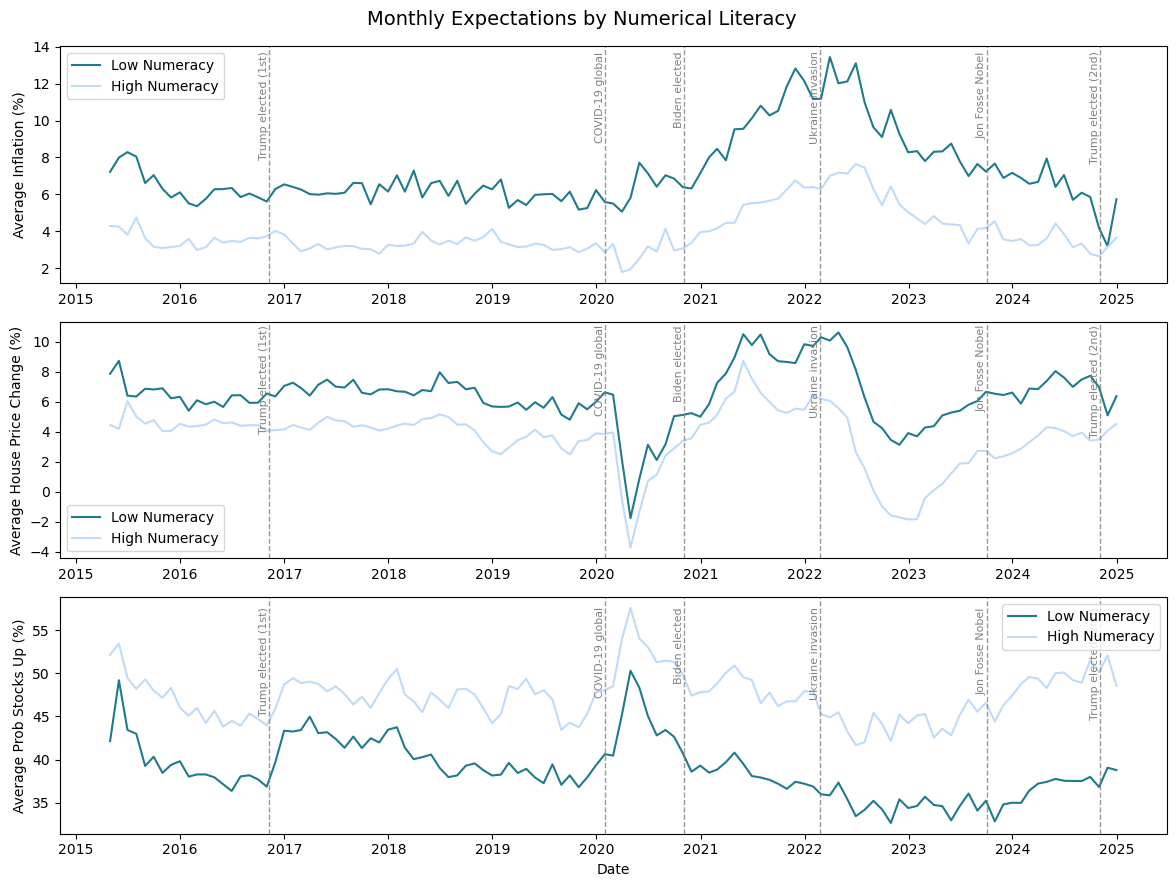

In [27]:
# Plot monthly expectations for low- vs high-numeracy respondents
fig = plot_group_timeseries(
    monthly_expectations["num_lit_high"],
    "num_lit_high",
    expectations_cols,
    "Numerical Literacy",
    colour1="#1F7A8C",
    colour2="#BFDBF7",
)

There are also Geopolitical and economic events that shift monthly expectations for both higher numerical literacy and below-median numerical literacy groups.

Although these fluctuations can be compared with the fluctuations within the Education level.
The similarity likely comes from the strong overlap between the two groups. Many college graduates also fall into the high-numeracy category. As a result, changes linked to education tend to move the numeracy groups in the same direction.

For stocks, the numeracy gap widens more: High-numeracy respondents are generally more optimistic in their expectations than low-numeracy, even when the college gap shrinks. This indicates that high numeracy boosts confidence in stocks beyond what education alone explains.

***
# Part 5
Compare monthly SCE inflation expectations with realized CPI inflation. Looking forward 12 months and backward 12 months to assess whether expectations anticipate future outcomes or if they are anchored in recent experience.
***


## 5.1 Realized future inflation

Compare the expectations to **realized** future inflation


In [28]:
# Load CPI data
cpi = pd.read_csv("data/CPI.csv", parse_dates=["DATE"])
# Align CPI timestamps with month-end to match survey aggregates
cpi["DATE"] = cpi["DATE"] + pd.offsets.MonthEnd(0)
# Keep date as the index for easier alignment
cpi = cpi.set_index("DATE")


## 5.1.1 Compute realized inflation

Using this monthly CPI data, computing the annual realized inflation over the next 12 months for each month

In [29]:
def compute_realized_inflation(cpi_df, months, column_name):
    """
    Calculate realized inflation over a forward or backward window.

    Parameters
    ----------
    cpi_df : pandas.DataFrame
        CPI series indexed by date with a `CPI` column.
    months : int
        Window length in months. Use positive values for forward-looking
        inflation (t to t+months) and negative values for backward-looking
        inflation (t-months to t).
    column_name : str
        Name for the resulting inflation column.

    Returns
    -------
    pandas.DataFrame
        Single-column DataFrame indexed by date containing the realized
        inflation percentage for each month in the usable window.
    """
    if months > 0:
        # Forward-looking: compare current CPI to the value months ahead
        base = cpi_df["CPI"]
        comparator = cpi_df["CPI"].shift(-months)
    else:
        # Backward-looking: compare CPI months ago to the current value
        lag = abs(months)
        base = cpi_df["CPI"].shift(lag)
        comparator = cpi_df["CPI"]
    rate = (comparator - base) / base * 100
    return rate.dropna().to_frame(column_name)

In [30]:
forward_inflation = compute_realized_inflation(
    cpi,
    months=12,
    column_name="inflation_realized_forward_12m",
)

## 5.1.2 Merge Expected Inflation with Realized Inflation
Merge the gender-level expected inflation series with the CPI-based realized inflation so each month has both numbers side by side.

In [31]:
# compute monthly expectations for the entire period, not juust 2015-2024
monthly_expectations_whole_period = compute_monthly_expectations(
    df, "female", expectations_cols, start="2013-01-01", end="2024-12-31"
)

# Start from the gender-specific monthly averages and keep only the columns we need
gender_expect = monthly_expectations_whole_period[
    ["date", "female", "inflation"]
].assign(gender=lambda s: s["female"].map({0: "Male", 1: "Female"}))

# Pivot to place the two gender series in separate columns indexed by month
gender_expect_pivot = gender_expect.pivot(
    index="date", columns="gender", values="inflation"
).rename(
    columns={"Male": "expected_inflation_male", "Female": "expected_inflation_female"}
)

# Join expected inflation with realized forward inflation so each month has both measures
gender_expect_vs_realized = gender_expect_pivot.join(forward_inflation, how="inner")

## 5.1.3 Scatter Plot and Correlation
Ploting male and female expectations against realized forward inflation, and displaing each panel’s correlation so we can judge how correlated they are


In [32]:
def plot_expected_vs_realized_scatter(
    data, expected_cols, realized_col, realized_label
):
    """
    Plot expected vs. realized inflation for each group and return the figure.

    Parameters
    ----------
    data : pandas.DataFrame
        Table containing the expected and realized inflation series, indexed by date.
    expected_cols : dict[str, str]
        Mapping from display label (e.g., 'Male') to the column holding that group's
        expected inflation.
    realized_col : str
        Column name with the realized inflation measure to plot on the y-axis.
    realized_label : str
        Human-readable label for the realized inflation axis (used in axis titles).

    Returns
    -------
    matplotlib.figure.Figure
        The figure object containing one scatter subplot per group.
    """
    fig, axes = plt.subplots(
        1, len(expected_cols), sharex=True, sharey=True, figsize=(12, 5)
    )
    axes = np.atleast_1d(axes)

    # Determine a common min/max so both axes use the same numeric range
    bounds = []
    for col in expected_cols.values():
        subset = data[[col, realized_col]].dropna()
        if subset.empty:
            continue
        bounds.append(subset.values.min())
        bounds.append(subset.values.max())

    lower = min(bounds)
    upper = max(bounds)
    pad = (upper - lower) * 0.05 or 0.5
    lower -= pad
    upper += pad

    for ax, (label, expected_col) in zip(axes, expected_cols.items()):
        subset = data[[expected_col, realized_col]].dropna()
        ax.scatter(
            subset[expected_col], subset[realized_col], alpha=0.8, edgecolor="none"
        )
        ax.set(
            title=label,
            xlabel="Expected inflation (%)",
            ylabel=f"{realized_label} (%)",
            xlim=(lower, upper),
            ylim=(lower, upper),
        )
        ax.tick_params(labelleft=True)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.text(
            0.04,
            0.94,
            rf"$\rho$ = {subset[expected_col].corr(subset[realized_col]):.2f}",
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=14,
            bbox={"facecolor": "white", "alpha": 0.8, "edgecolor": "none"},
        )

    return fig

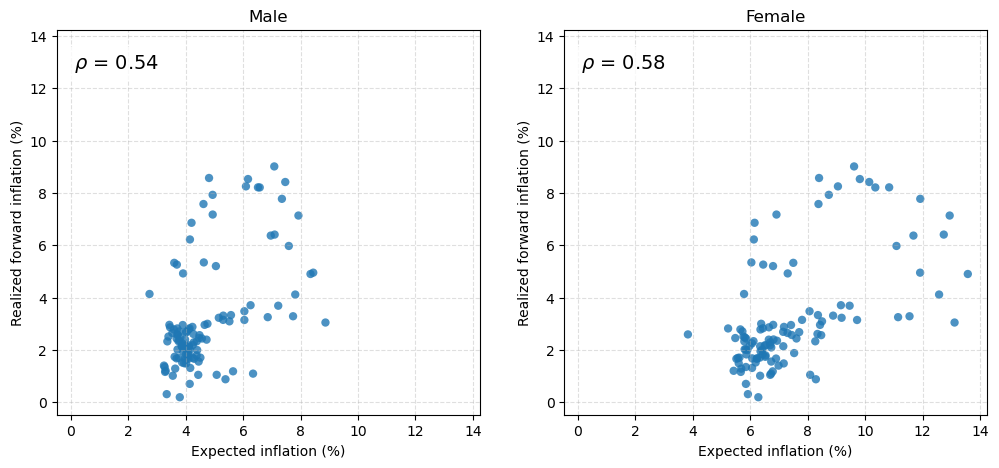

In [33]:
# Map the panel labels to the corresponding expected-inflation columns
expected_cols = {
    "Male": "expected_inflation_male",
    "Female": "expected_inflation_female",
}

fig = plot_expected_vs_realized_scatter(
    gender_expect_vs_realized,
    expected_cols,
    "inflation_realized_forward_12m",
    "Realized forward inflation",
)

## 5.2 Merge with past realized inflation and compare correlations
Repeat steps from 5.1, but with past realized inflation 

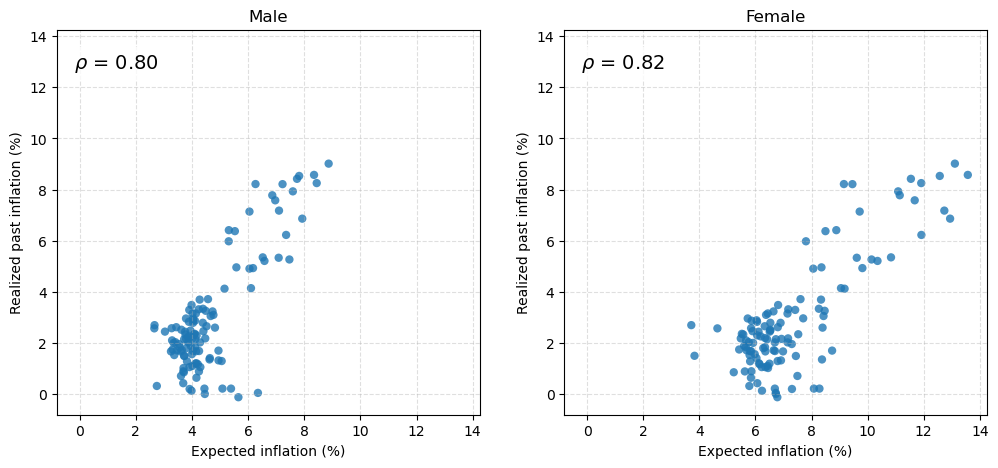

In [34]:
# Compute backward-looking (past 12 months) realized inflation from the CPI series
past_inflation = compute_realized_inflation(
    cpi,
    months=-12,
    column_name="inflation_realized_backward_12m",
)

# Align expected inflation with the past-realized series so each month has both values
gender_expect_vs_past = gender_expect_pivot.join(past_inflation, how="inner")

fig = plot_expected_vs_realized_scatter(
    gender_expect_vs_past,
    expected_cols,
    "inflation_realized_backward_12m",
    "Realized past inflation",
)

### Evaluation of the scatter plots:
**What the correlations show:**

Forward-looking correlations (ρ=0.54 for men, 0.58 for women) are only moderate, whereas the backward-looking correlations increase to 0.80 and 0.82. This shows that future expectations are significantly anchored in recent inflation rather than accurately anticipating future inflation. In other words, instead of anticipating future inflation rationally, one instead extrapolates from past trends, adaptive rather than rational behaviour.


**Gender comparison:**

In both forward- and backward-looking correlations, the gender gap is negligible, supporting the idea of information sharing being equal among genders influenced by news, prices, etc. As discussed earlier, women tend to expect slightly higher inflation on average; however, the difference in correlation between expectations and realized inflation is insignificant. The male data hugs the 45° line (correlation line) a bit more closely, so their expectations sit nearer to realized forward inflation, though not a strong correlation. Both males and females are generally too pessimistic when predicting future inflation (they "fear" more inflation than what actually occurs) and therefore bias upwards to realized inflation.


**Summary:**

Overall, both groups exhibit adaptive expectations, and neither gender stands out as a significantly better forecaster. This indicates a general pessimistic bias in their inflation expectations.

### AI statement and sources:
This term paper was written and coded by the group members. AI helped polish wording, formatting docstrings, comments and looking over the final product. We used the lectures and workshops in tech2 as sources.